A notebook to fiddle around with ONC data. Trying to divide ONC data into casts.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import os
import datetime
import netCDF4 as nc
import seaborn as sns
import glob

import ONC_patrols as onc

from salishsea_tools import tidetools, viz_tools
from nowcast import figures
import comparisons

%matplotlib inline

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_color_codes()

In [3]:
grid_B=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh_mask=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

In [4]:
NOWCAST_PATH = '/results/SalishSea/nowcast/'

In [5]:
csvfile = "/ocean/nsoontie/MEOPAR/ONC/Patrols/Victoria_Patrol9_CTD_20150220T182104Z_20151001T195734Z-Corrected.csv"
data=onc.load_patrol_csv(csvfile)

Exlude bad data

In [6]:
data = onc.exclude_bad(data,['Practical Salinity Corrected QC Flag  '], [0,4,9])

Divde into casts

In [7]:
data = onc.divide_into_casts(data)

In [8]:
def results_dataset(period, grid, date):
    
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_{}_{}_{}_{}.nc'.format(period,datestr,datestr,grid)
    return nc.Dataset(os.path.join(NOWCAST_PATH,sub_dir,fname))

In [9]:
def cast_position_and_time(cast):
    """Retrieve ONC cast average longitude, latitude and minimum time.
    
    :arg cast: the ONC cast
    :type cast: a single group of pandas grouby object
    
    :returns: lon, lat, date
    """
    
    lon = cast['Longitude Corrected (deg)'].mean()
    lat = cast['Latitude Corrected (deg)'].mean()
    date = cast['day'].min()
    
    return lat, lon, date

In [10]:
def retrieve_nowcast_data(lon, lat, date, obs_depth, field, grid_B, mesh_mask):
    """Gather nowcast field daily mean, min and max at lat, lon on date, interpolated to obs_depth.
    
    :arg lon: longitude point
    :type lon: real number
    
    :arg lat: latitude point
    :type lat: real number
    
    :arg date: simulation date
    :type date: datetime
    
    :arg obs_depth: array of depths to be interpolated to
    :type obs_depth: numpy array
    
    :arg field: name of variable to load, e.g 'vosaline' or 'votemper'
    :type field: string
    
    :arg grid_B: model bathymetry
    :type grid_B: netCDF4 object
    
    :arg mesh_mask: model mesh mask
    :type mesh_mask: netCDF4 object
    
    :returns: model_d_interp, model_max, model_min - numpy arrays
    """
    # look up model grid point
    bathy, lons, lats = tidetools.get_bathy_data(grid_B)
    j, i = tidetools.find_closest_model_point(lon, lat, lons, lats, bathy)
    # loading
    grid_d = results_dataset('1d', 'grid_T', date)
    grid_h = results_dataset('1h', 'grid_T', date)   
    model_d = grid_d.variables[field][0, :, j, i]
    model_h = grid_h.variables[field][:, :, j, i]
    gdep = mesh_mask.variables['gdept'][0, :, j, i]
    # masking
    tmask = mesh_mask.variables['tmask'][:, :, j, i]
    tmask = 1- tmask +np.zeros(model_h.shape) 
    model_d = np.ma.array(model_d,mask=tmask[0,:])
    gdep_mask = np.ma.array(gdep,mask=tmask[0,:])
    model_h = np.ma.array(model_h,mask=tmask)
    # interpolate to observed depth
    model_d_interp = comparisons.interpolate_depth(model_d, gdep_mask, obs_depth)
    model_h_interp = np.zeros((model_h.shape[0],len(obs_depth)))
    for t in np.arange(model_h.shape[0]):
        model_h_interp[t,:] = comparisons.interpolate_depth(model_h[t,:], gdep_mask, obs_depth)
    # daily max and min
    model_max = np.max(model_h_interp,axis=0)
    model_min = np.min(model_h_interp,axis=0)
    
    return model_d_interp, model_max, model_min
    

In [11]:
def plot_profile_comparison(ax, cast, model_d_interp, var_name, var_lims, depth_lims):
    """Plot cast depth profile comparison between model and observations
    
    :arg ax: axis for plotting
    :type ax: axis object
    
    :arg cast: the observed cast for comaprison
    :type cast: pandas DataFrame-like object
    
    :arg model_d_interp: model values interpolated to observed depths
    :type model_d_interp: numpy array
    
    :arg var_name: observed variable name, eg 'Practical Salinity Corrected (psu)'
    :type var_name: string
    
    :arg var_lims: min/max variable values, eg [29,34]
    :type var_lims: 2-tuple
    
    :arg depth_lims: min/max depth values, eg [0,150]
    :type depth_lims: 2-tuple
    
    :returns: lo, lm - scatter plot handles for observations and model.
    Can be used for adding a legend later.
    """
    
    lo = ax.scatter(cast[var_name], cast['Depth Corrected (m)'], c='g', label='Observed')
    lm = ax.scatter(model_d_interp, cast['Depth Corrected (m)'], c='b', label='Modelled')

    ax.set_ylim([depth_lims[-1], depth_lims[0]])
    ax.set_ylabel('Depth [m]')
    
    ax.set_xlim(var_lims)
    ax.set_xlabel(var_name)
    
    ax.set_title(cast.day.min().strftime('%Y-%m-%d'))
    
    return lo, lm

In [12]:
def plot_map(ax, cast, grid_B, xlims, ylims):
    """ Plot the location of cast lon/lat on a map.
    
    :arg ax: axis for plotting
    :type ax: axis object
    
    :arg cast: the observed cast
    :type cast: pandas DataFrame-like object
    
    :arg grid_B: model bathymetry
    :type grid_B: netCDF4 object
    
    :arg xlims: min/max longitudes, eg [-124,-123]
    :type xlims: 2-tuple
    
    :arg ylims: min/max latitudes, eg [48,49]
    :type ylims: 2-tuple
    
    """
    cast.plot(x='Longitude Corrected (deg)', y='Latitude Corrected (deg)', kind='scatter', ax=ax)
    viz_tools.plot_coastline(ax, grid_B,coords='map')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_title(cast.day.min().strftime('%Y-%m-%d'))

In [13]:
def plot_scatter_comparison(ax, cast, model_d_interp, model_max, model_min, var_name, var_lims, depth_lims):
    """Scatter plot to compare observed and model daily average values. 
    Plots model error bars based on model daily max/min.
    Points are coloured by depth
    
    :arg ax: axis for plotting
    :type ax: axis object
    
    :arg cast: the observed cast for comaprison
    :type cast: pandas DataFrame-like object
    
    :arg model_d_interp: model values interpolated to observed depths
    :type model_d_interp: numpy array
    
    :arg model_max: model daily maximum interpolated to observed depths
    :type model_max: numpy array
    
    :arg model_min: model daily minimum interpolated to observed depths
    :type model_min: numpy array
    
    :arg var_name: observed variable name, eg 'Practical Salinity Corrected (psu)'
    :type var_name: string
    
    :arg var_lims: min/max variable values, eg [29,34]
    :type var_lims: 2-tuple
    
    :arg depth_lims: min/max depth values, eg [0,150]
    :type depth_lims: 2-tuple
    
    :returns: mesh - scatter plot depth colors.
    Can be used for adding a colorbar.
    """
    yerr= [model_d_interp-model_min,model_max-model_d_interp]
    ax.errorbar(cast[var_name], model_d_interp,yerr=yerr,fmt='k:',
               ecolor='gray',marker='',zorder=0)
    mesh=ax.scatter(cast[var_name], model_d_interp,
                    c=cast['Depth Corrected (m)'],cmap='Spectral', norm=mcolors.LogNorm(),
                    vmin=depth_lims[0]+.5, vmax=depth_lims[1])
    ax.plot(var_lims,var_lims,'r')
    ax.set_ylim(var_lims)
    ax.set_xlim(var_lims)
    ax.set_xlabel('Observed {}'.format(var_name))
    ax.set_ylabel('Modelled {}'.format(var_name))
    ax.set_title(cast.day.min().strftime('%Y-%m-%d'))
    return mesh

In [14]:
def compare_patrol_model_obs(data, names, var_lims=[29,34], depth_lims =[0,160],
                      xlims=[-124,-123], ylims=[48,49]):
    """ Compare model and observations for all ctd casts in data.
    For each day in data this code produces
    a. A scatter plot of obs vs data
    b. A obs vs data depth profile comparison
    c. A map with observed lon/lats in the comaparison
        
    :arg data: observed data from an ONC patrols
    It is a good idea to exclude data points with low QC
    :type data: pandas DataFrame
    
    :arg names: dictionary with observed, model variable name mapping
    e.g names = {'obs': 'Practical Salinity Corrected (psu)', 'model': 'vosaline' }
    :type names: dictionary
    
    :arg var_lims: min/max variable values, eg [29,34]
    :type var_lims: 2-tuple
    
    :arg depth_lims: min/max depth values, eg [0,150]
    :type depth_lims: 2-tuple
    
    :arg xlims: min/max longitudes, eg [-124,-123]
    :type xlims: 2-tuple
    
    :arg ylims: min/max latitudes, eg [48,49]
    :type ylims: 2-tuple
    """

    # Observed and model field names
    var_name = names['obs']
    field = names['model']
    # Loop through days
    data_days, days = onc.list_days(data)
    for d in days:
        daily = data_days.get_group(d).dropna()    
        daily_casts = daily.groupby('Cast')
        fig,axs=plt.subplots(1,3,figsize=(15,3))
        # Loop through casts in a day
        for c in daily_casts.groups:
            cast = daily_casts.get_group(c)
            lat, lon, date = cast_position_and_time(cast)
            obs_depth = np.array(cast['Depth Corrected (m)'][:])
            try: 
                model_d_interp, model_max, model_min = retrieve_nowcast_data(lon, lat, date, obs_depth,
                                                                             field, grid_B, mesh_mask)
                mesh = plot_scatter_comparison(axs[0], cast, model_d_interp, model_max, model_min, 
                                               var_name, var_lims, depth_lims)
                lo, lm = plot_profile_comparison(axs[1], cast, model_d_interp, var_name, var_lims, depth_lims)
                plot_map(axs[2], cast, grid_B, xlims, ylims)
            except IndexError:
                print('No Model Point for {} {}'.format(cast['Longitude Corrected (deg)'].mean(),
                                               cast['Latitude Corrected (deg)'].mean()))
        # Label colorbar, etc
        cbar = plt.colorbar(mesh,ax=axs[0])
        cbar.set_label('Depth (m)')
        ticks = [1, 10, 25, 50, 100, 200, 400]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels(ticks)
    
        axs[1].legend([lo,lm],['Observed', 'Modelled'])
        

No Model Point for -123.30147711249997 48.334551287500005
No Model Point for -123.30579209999999 48.33254605
No Model Point for -123.18295900000003 48.461194
No Model Point for -123.44497209090906 48.3592954090909


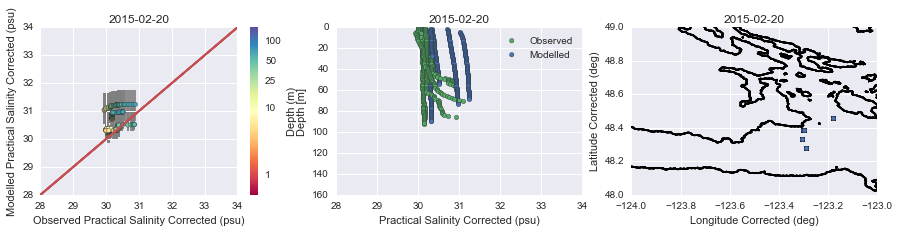

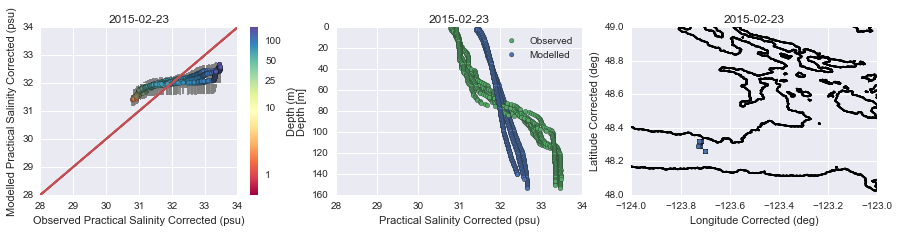

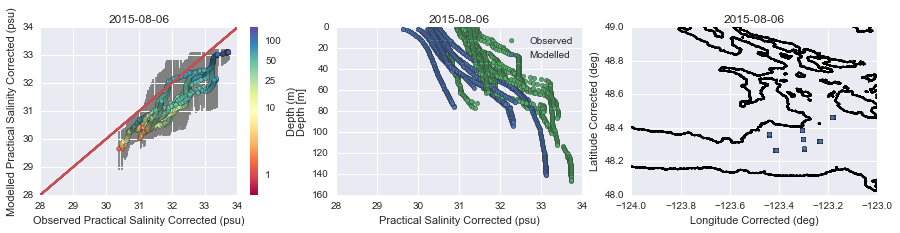

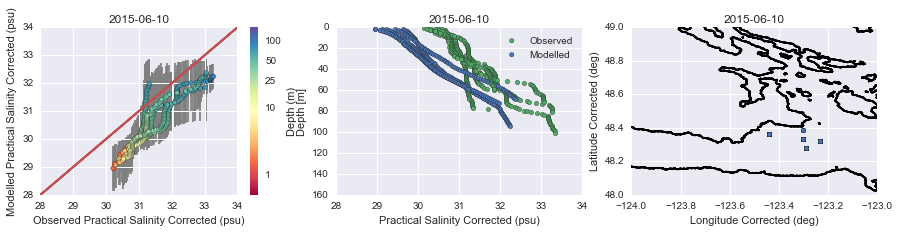

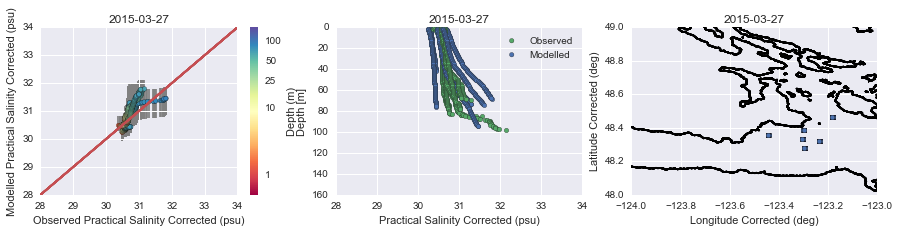

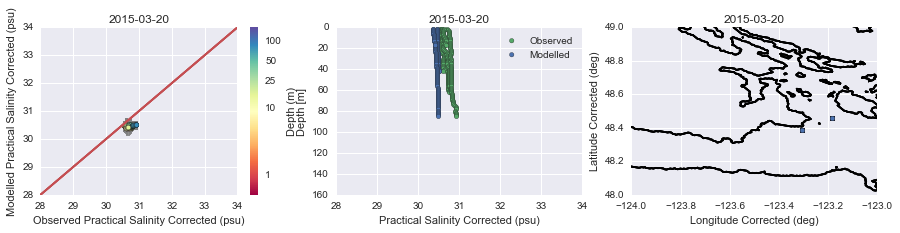

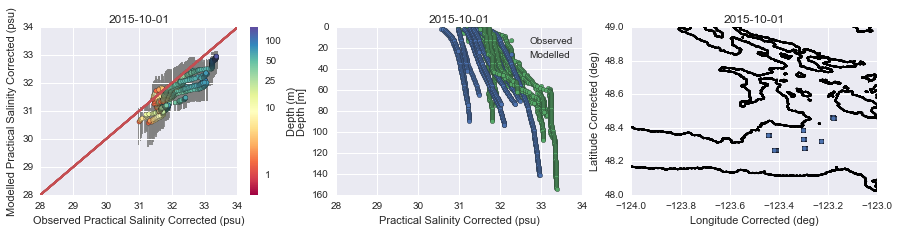

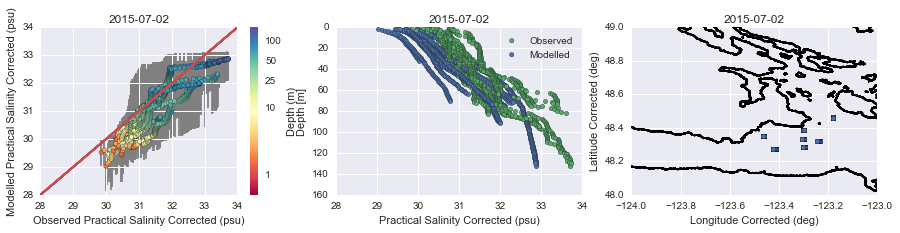

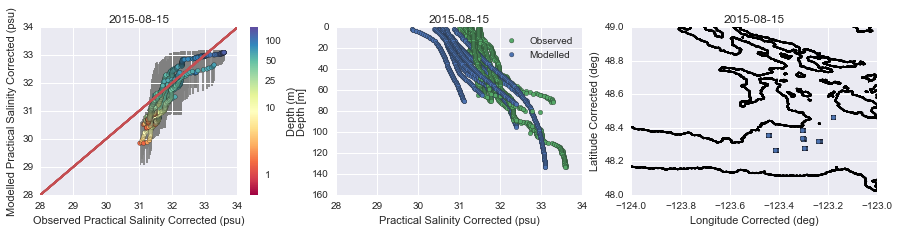

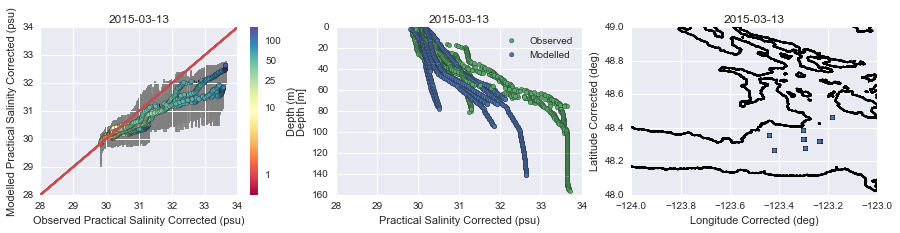

In [15]:
names={'obs': 'Practical Salinity Corrected (psu)',
       'model': 'vosaline'}
compare_patrol_model_obs(data, names,var_lims=[28,34])

No Model Point for -123.30147711249997 48.334551287500005
No Model Point for -123.30579209999999 48.33254605
No Model Point for -123.18295900000003 48.461194
No Model Point for -123.44497209090906 48.3592954090909


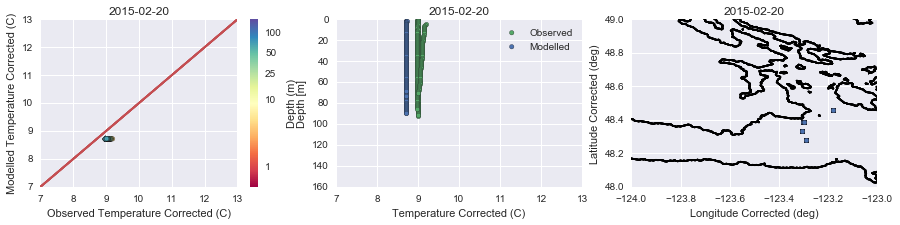

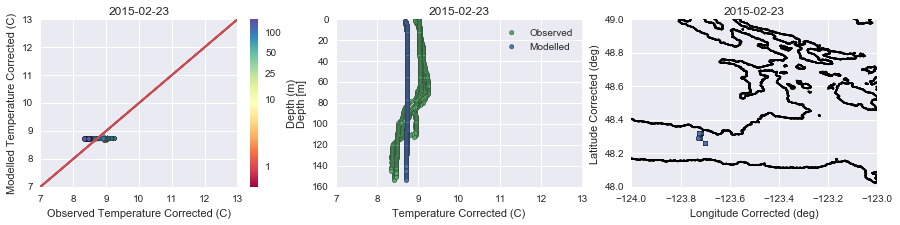

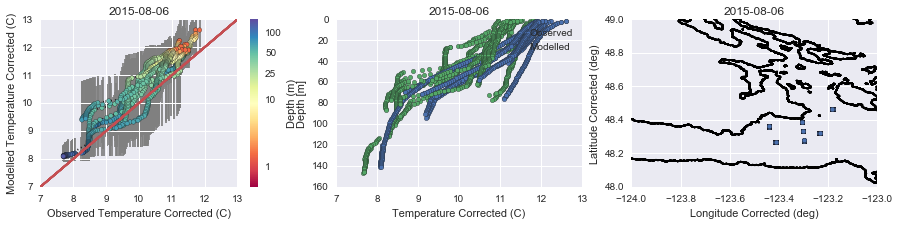

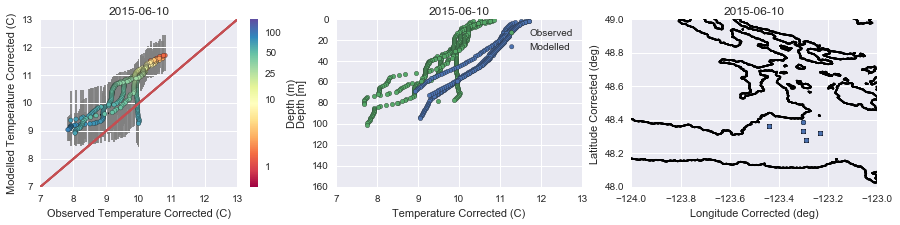

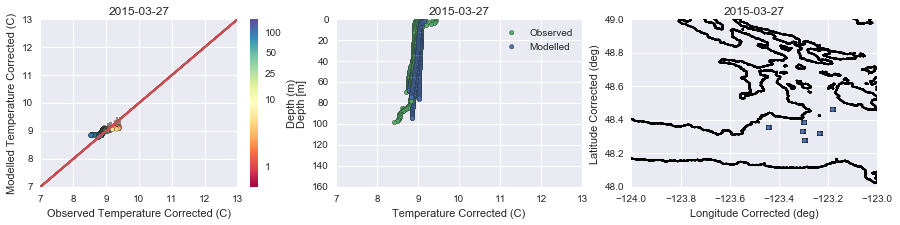

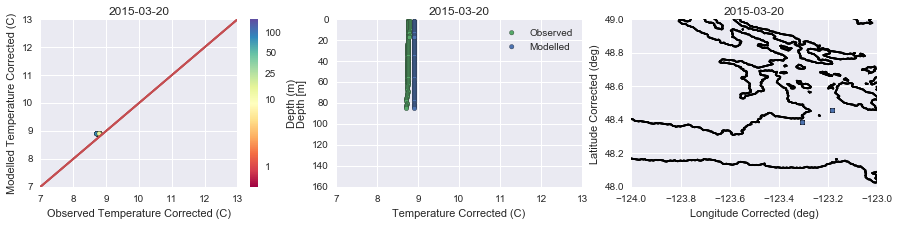

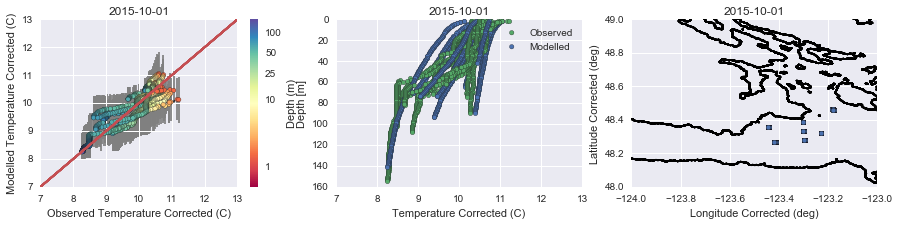

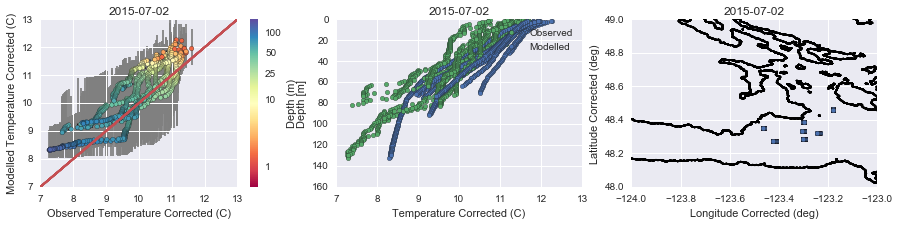

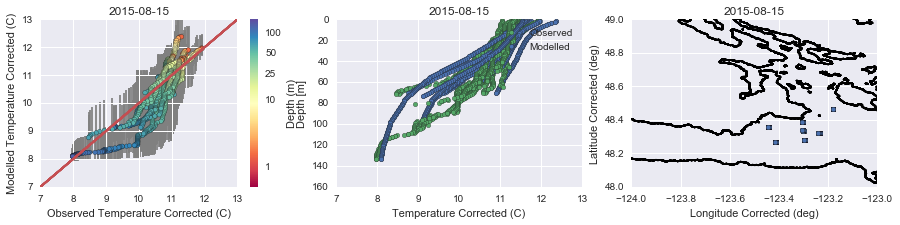

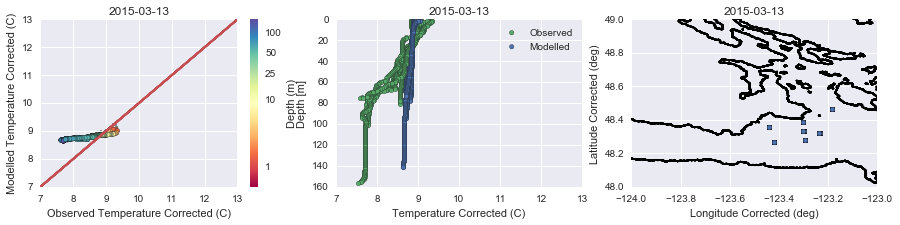

In [16]:
names={'obs': 'Temperature Corrected (C)',
       'model': 'votemper'}
compare_patrol_model_obs(data, names, var_lims=[7,13])